In [38]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch

In [39]:
import random

import numpy as np
import torch

def set_seed(seed):
    """Set all seeds for reproducibility"""
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # PyTorch multi-GPU
    torch.backends.cudnn.deterministic = True  # CUDNN
    torch.backends.cudnn.benchmark = False  # CUDNN

In [40]:
set_seed(42)

In [41]:
# Data
data_path = 'dataset.npz'

# Read data
data = np.load(data_path)
input_data = data['input_data']
output_data = data['output_data']

# Train test split
train_input = input_data[:900000]
train_output = output_data[:900000]
test_input = input_data[900000:]
test_output = output_data[900000:]

# Data to tensor
train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_output = torch.tensor(test_output, dtype=torch.float32)

In [42]:
print(train_input.shape, train_output.shape, test_input.shape, test_output.shape)

torch.Size([900000, 3]) torch.Size([900000, 2]) torch.Size([100000, 3]) torch.Size([100000, 2])


In [43]:
# Define a simple MLP (Multi-Layer Perceptron) for Harmonic Oscillator
class HarmonicMLP(torch.nn.Module):
    def __init__(self, input_size=3, hidden_size=1024, output_size=2, num_layers=4):
        super(HarmonicMLP, self).__init__()
        
        # Input layer
        layers = [torch.nn.Linear(input_size, hidden_size), 
                 torch.nn.GELU()]
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.extend([
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.GELU()
            ])
        
        # Output layer
        layers.append(torch.nn.Linear(hidden_size, output_size))
        
        # Sequential container
        self.model = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return x[:, :2] + self.model(x)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data to device
train_input = train_input.to(device)
train_output = train_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

print(f"Train input shape: {train_input.shape}, Train output shape: {train_output.shape}")
print(f"Test input shape: {test_input.shape}, Test output shape: {test_output.shape}")

# Create model and move to device
model = HarmonicMLP().to(device)

Train input shape: torch.Size([900000, 3]), Train output shape: torch.Size([900000, 2])
Test input shape: torch.Size([100000, 3]), Test output shape: torch.Size([100000, 2])


In [45]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()

# Define optimizer with AdamW instead of Adam
lr = 1e-4
min_lr = 1e-7
weight_decay = 1e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define cosine annealing learning rate scheduler
num_epochs = 100  # Define total number of epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Starting training...
Epoch [10/100], Train Loss: 0.000121, Val Loss: 0.000130, LR: 0.000098
Epoch [20/100], Train Loss: 0.000029, Val Loss: 0.000043, LR: 0.000090
Epoch [30/100], Train Loss: 0.000005, Val Loss: 0.000003, LR: 0.000079
Epoch [40/100], Train Loss: 0.000007, Val Loss: 0.000006, LR: 0.000065
Epoch [50/100], Train Loss: 0.000001, Val Loss: 0.000001, LR: 0.000050
Epoch [60/100], Train Loss: 0.000001, Val Loss: 0.000001, LR: 0.000035
Epoch [70/100], Train Loss: 0.000000, Val Loss: 0.000000, LR: 0.000021
Epoch [80/100], Train Loss: 0.000000, Val Loss: 0.000000, LR: 0.000010
Epoch [90/100], Train Loss: 0.000000, Val Loss: 0.000000, LR: 0.000002
Epoch [100/100], Train Loss: 0.000000, Val Loss: 0.000000, LR: 0.000000
Training completed. Best validation loss: 0.000000


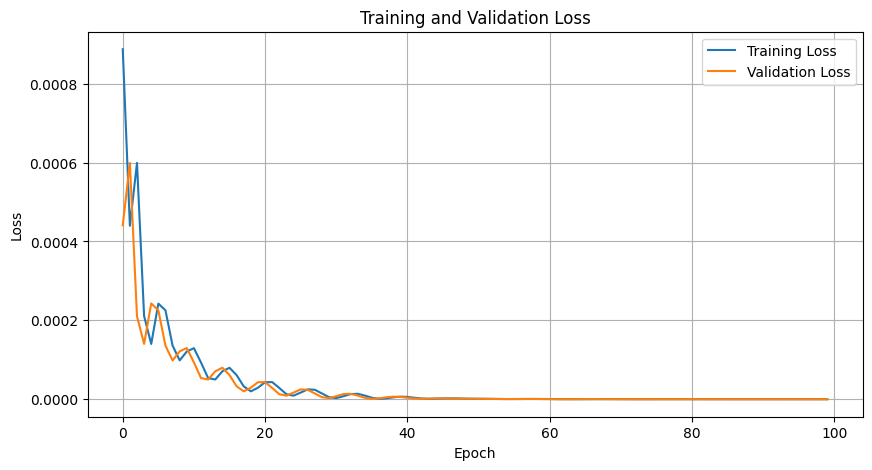

In [46]:
# Training loop
train_losses = []  # To track the training loss values
valid_losses = []  # To track the validation loss values
best_loss = float('inf')
best_model_state = None

print("Starting training...")
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # Forward pass on training data
    outputs = model(train_input)
    train_loss = criterion(outputs, train_output)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Update learning rate
    scheduler.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_input)
        val_loss = criterion(val_outputs, test_output)
    
    # Save losses for plotting
    train_losses.append(train_loss.item())
    valid_losses.append(val_loss.item())
    
    # Save best model based on validation loss
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        best_model_state = model.state_dict().copy()
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}, LR: {scheduler.get_last_lr()[0]:.6f}')

# Load best model
model.load_state_dict(best_model_state)
print(f"Training completed. Best validation loss: {best_loss:.6f}")

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# Save the best model state_dict to a file
model_save_path = 'best_model.pth'
torch.save(best_model_state, model_save_path)
print(f"Model state_dict saved to {model_save_path}")

Model state_dict saved to best_model.pth


In [48]:
# Load the model from the saved state_dict
loaded_model = HarmonicMLP().to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()
print(f"Model loaded from {model_save_path}")

Model loaded from best_model.pth


In [49]:
# Generate a random input of size 1, 3 and make a prediction
random_input = torch.randn(1, 3).to(device)
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model(random_input)
    
print("Random input:")
print(random_input)
print("\nModel prediction:")
print(prediction)

Random input:
tensor([[-1.5507, -0.7936, -1.0185]], device='cuda:0')

Model prediction:
tensor([[-1.5611, -0.7869]], device='cuda:0')
